# Cholera

In [1]:

import os
#os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax
import itertools
import numpy as onp

import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *


import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2024-11-07 13:51:50.335844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('data/dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('data/dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(onp.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)#[20:]
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**(-3)), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 17.3, 0.057, 0, 9.8, onp.exp(-4.8), 0.999999, (-5.0*10**(-3)), 3.2, 0.25, np.array([1.2,6.2,-3.4,3.9,3.2,4.3]), 3, 0.02


gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = onp.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))


theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [3]:
pfilter(theta, ys, 10000, covars, thresh=-1)

Array(3747.9526, dtype=float32)

In [3]:
mop(theta, ys, 10000, covars, alpha=0.5)

Array(3749.1624, dtype=float32)

In [ ]:
n_trials = 100
J = 10000

def get_rand_theta():
    return transform_thetas(onp.random.uniform(10.00, 40.00),
                onp.random.uniform(0.03, 0.60), 
                         rho, 
                 onp.random.uniform(0.20, 30.00), 
                         omega, 
                         c, 
                 onp.random.uniform(-1.00, 0.00)*0.01, 
                 onp.random.uniform(1.00, 5.00), 
                 onp.random.uniform(0.10, 0.50), 
                 onp.random.uniform(0,8,size=6)+np.array([-4,0,-4,0,0,0]), 
                 onp.random.uniform(-10,0,size=6))

def get_sds():    
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    return (highs-lows)/100



def get_rand_theta(J=J):
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    rands = onp.array(onp.repeat(((lows+highs)/2)[None,:], J, axis=0)).T
    rands[~onp.isinf(lows)] = onp.random.uniform(lows[~onp.isinf(lows)], 
                       highs[~onp.isinf(highs)],
                       size=(J, len(highs[~onp.isinf(highs)]))).T
    return rands.T
                       
                       


sigmas = (np.abs(theta)/600)
theta_ests = theta + 60*sigmas*onp.random.normal(size=theta.shape) #6 for close to maxima
#theta_ests = get_rand_theta(J).mean(0)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
print(pfilter(theta_ests, ys, J, covars, thresh=-1))
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})
get_thetas(theta_ests)

# try cross-comparison, fig 2 in pnas, on close to MLE
# use if2 settings

In [4]:
def log_in_bbox(theta):    
    valids = np.array([i for i in range(len(theta)) if i not in [2,5]])
    lows = transform_thetas(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             onp.zeros(6)+onp.array([-4,0,-4,0,0,0]), 
            -10*onp.ones(6))
    highs = transform_thetas(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*onp.ones(6)+onp.array([-4,0,-4,0,0,0]), 
                onp.zeros(6))
    #theta = highs+1
    #theta = lows-1
    return -100*np.log(1-(np.logical_or(np.any(lows[valids] > theta[valids]),
                                        np.any(theta[valids] > highs[valids])))+1e-43)

log_in_bbox(theta+9999)

Array(9901.625, dtype=float32, weak_type=True)

In [ ]:
import tensorflow_probability as tfp
from tensorflow_probability.substrates.jax.mcmc import \
        NoUTurnSampler, MetropolisAdjustedLangevinAlgorithm, \
        RandomWalkMetropolis, random_walk_normal_fn
import tensorflow as tf


mif_init = True
chains = 4
for chain in range(chains):
    if mif_init:
        bbox = get_rand_theta(1).squeeze()
        mif_logliks_warm, mif_params_warm = mif(bbox, ys, sigmas=0.02, 
                                  sigmas_init = 1e-20, covars=covars, verbose=False,
                                  M=40, J=J, a=0.95, monitor=True, thresh=-1) 
        theta_nuts = mif_params_warm[mif_logliks_warm.argmin()].mean(0)
        valid_coords = [i for i in range(len(theta)) if i not in [2,5]]
        kde = jax.scipy.stats.gaussian_kde(mif_params_warm[mif_logliks_warm.argmin()][:,valid_coords].T)
        def dprior(theta):
            return -kde.logpdf(theta[valid_coords,None]).sum()/len(ys)
    else:
        theta_nuts = get_rand_theta(1)[0]
        def dprior(theta):
            return 0.
    
    #log_in_bbox
    states = tfp.substrates.jax.mcmc.sample_chain(
        num_results=1500,
        num_burnin_steps=0, 
        current_state=theta_nuts,
        kernel=NoUTurnSampler(
            lambda theta: -mop_mean(theta, ys=ys, J=1000, covars=covars, alpha=0.97, key=None)-dprior(theta),
            0.05,
            max_tree_depth=5,
            max_energy_diff=1000.0,
            unrolled_leapfrog_steps=1,
            parallel_iterations=1,
            experimental_shard_axis_names=None,
            name=None),
        trace_fn=None,
        seed=jax.random.PRNGKey(chain))
    # RandomWalkMetropolis(
    #         lambda theta: -mop_mean(theta, ys=ys, J=10000, covars=covars, alpha=0.95, key=None)-dprior(theta),
    #         new_state_fn = random_walk_normal_fn(scale=get_sds())
    #     )
    
    np.save('outs/pmcmc/nuts_eb/thetas/theta_'+str(chain)+'.npy', np.array(states))

100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


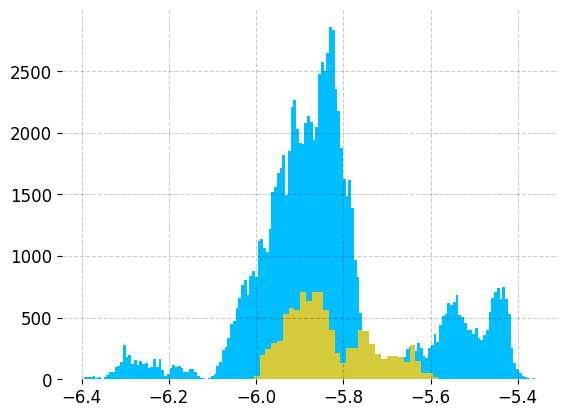

In [32]:
plt.hist(mif_params_warm[-10:,:,4].flatten(), bins='auto')
plt.hist(mif_params_warm[mif_logliks_warm.argmin(),:,4].flatten(), bins='auto')
plt.show()

In [ ]:
chains=4
thetas_chains = np.array([np.load('outs/pmcmc/mh_eb/thetas/theta_'+str(chain)+'.npy') 
                          for chain in range(chains)])
#thetas_chains = np.array([np.load('outs/pmcmc/nuts/thetas/theta_'+str(chain)+'.npy') 
#                          for chain in range(chains)])
thetas_chains = np.array([np.load('outs/pmcmc/nuts_eb/thetas/theta_'+str(chain)+'.npy') 
                          for chain in range(chains)])
#logliks_chains = np.array([np.load('outs/pmcmc/logliks/loglik_'+str(chain)+'.npy') 
#                          for chain in range(chains)])
thetas_chains.shape

Text(0.5, 1.0, 'Plot of V_m for 4 Chains Over Time')

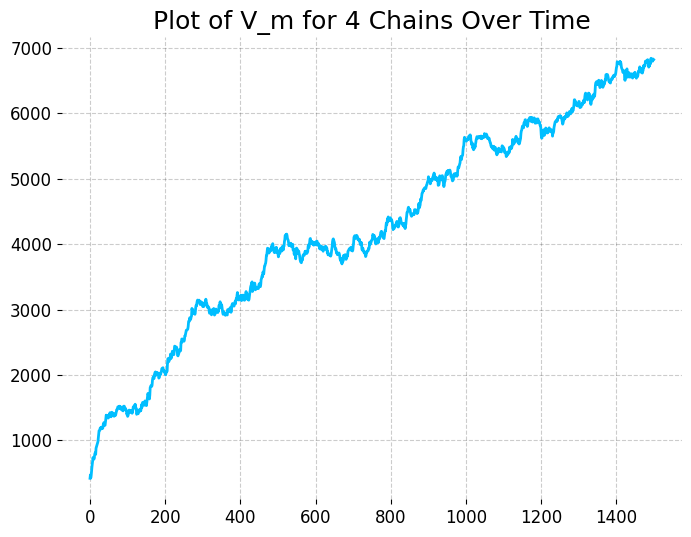

In [11]:
plt.figure(figsize=(8,6))
plt.plot(np.nansum(thetas_chains.std(0)/0.05,-1))

plt.title('Plot of V_m for 4 Chains Over Time')

In [ ]:
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
plt.style.use('matplotlibrc')
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16/1.5,9/1.5))
skip = 1
col = 6
burnin = 500
thetas_chains = np.array([np.load('outs/pmcmc/nuts_eb/thetas/theta_'+str(chain)+'.npy') 
                          for chain in range(chains)])
for chain in range(chains):
    ax[0,0].hist(thetas_chains[chain][burnin::skip,col], alpha=0.7, density=True)
    sns.kdeplot(thetas_chains[chain][burnin::skip,col], ax=ax[0,1])
    ax[1,1].plot(thetas_chains[chain][::skip,col], alpha=0.9)
    plot_acf(thetas_chains[chain][::skip,col], ax=ax[1,0])
ax[0,0].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[0,1].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[1,1].axvline(burnin, color='black', linestyle='--', label='Burn-in Period')
ax[0,0].set_title('Posterior Histogram', fontsize=24)
ax[0,1].set_title('Posterior Density', fontsize=24)
ax[1,0].set_title('Autocorrelation', fontsize=24)
ax[1,1].set_title('Trace Plot', fontsize=24)
ax[0,0].legend(fontsize=16)
ax[0,1].legend(fontsize=16)
ax[1,1].legend(fontsize=16)
plt.suptitle('MCMC Diagnostics', fontsize=28)
ax[0,0].tick_params(labelsize=20)
ax[0,1].tick_params(labelsize=20)
ax[1,0].tick_params(labelsize=20)
ax[1,1].tick_params(labelsize=20)
plt.tight_layout()

plt.savefig('imgs/pmcmc/nuts_eb.png', dpi=300)

# NUTS

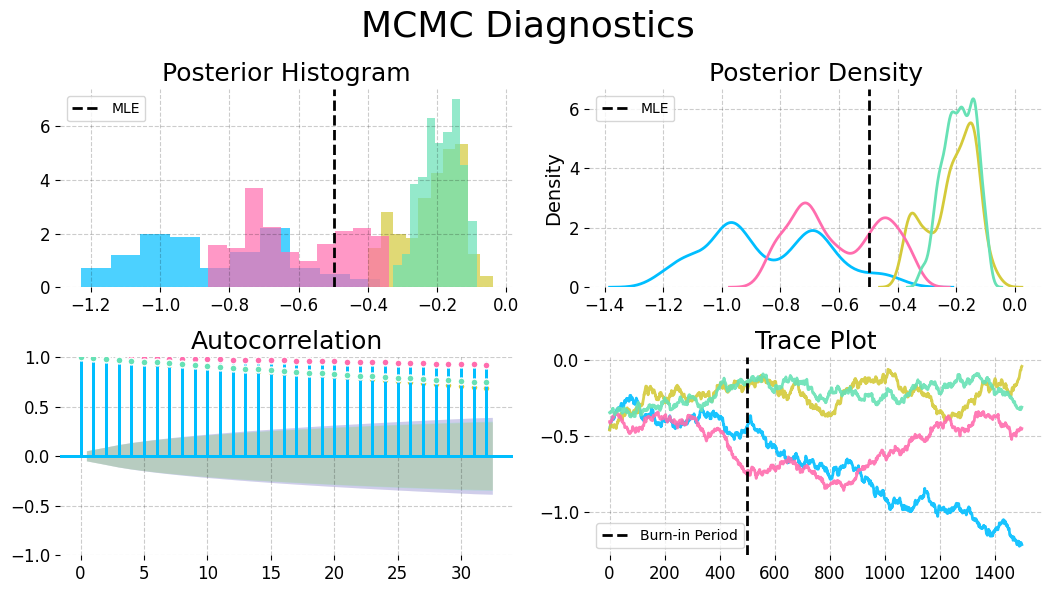

In [10]:
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
plt.style.use('matplotlibrc')
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16/1.5,9/1.5))
skip = 1
col = 6
burnin = 500
thetas_chains = np.array([np.load('outs/pmcmc/mh_eb/thetas/theta_'+str(chain)+'.npy') 
                          for chain in range(chains)])
for chain in range(chains):
    ax[0,0].hist(thetas_chains[chain][burnin::skip,col], alpha=0.7, density=True)
    sns.kdeplot(thetas_chains[chain][burnin::skip,col], ax=ax[0,1])
    ax[1,1].plot(thetas_chains[chain][::skip,col], alpha=0.9)
    plot_acf(thetas_chains[chain][::skip,col], ax=ax[1,0])
ax[0,0].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[0,1].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[1,1].axvline(burnin, color='black', linestyle='--', label='Burn-in Period')
ax[0,0].set_title('Posterior Histogram')
ax[0,1].set_title('Posterior Density')
ax[1,1].set_title('Trace Plot')
ax[0,0].legend()
ax[0,1].legend()
ax[1,1].legend()
plt.suptitle('MCMC Diagnostics', fontsize=26)
plt.tight_layout()


plt.savefig('imgs/pmcmc/mh.png', dpi=300)
# MH

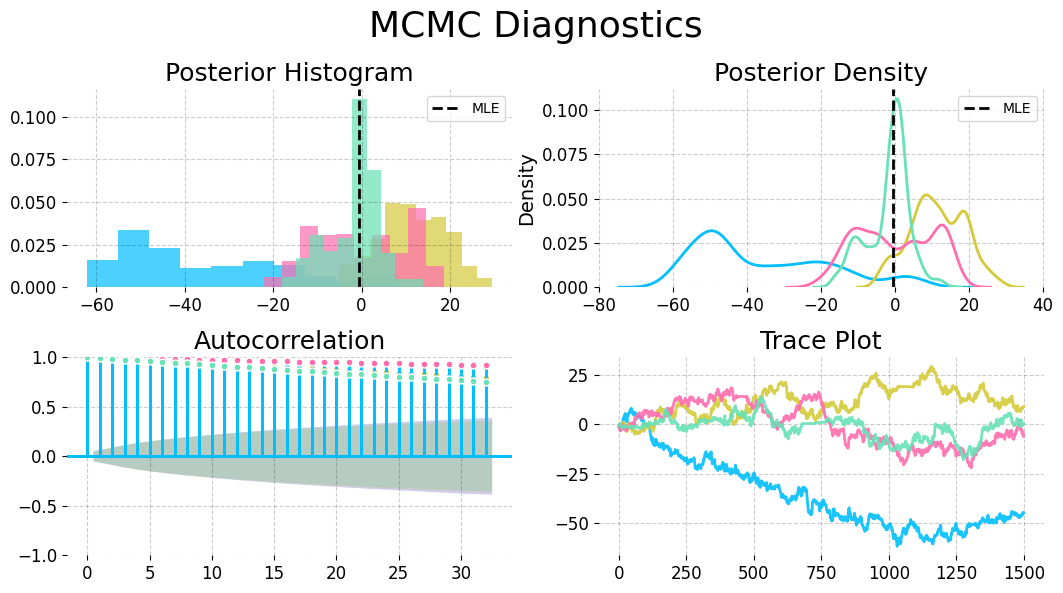

In [9]:
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
plt.style.use('matplotlibrc')
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16/1.5,9/1.5))
skip = 1
col = 6
thetas_chains = np.array([np.load('outs/pmcmc/nuts/thetas/theta_'+str(chain)+'.npy') 
                          for chain in range(chains)])
for chain in range(chains):
    ax[0,0].hist(thetas_chains[chain][::skip,col], alpha=0.7, density=True)
    sns.kdeplot(thetas_chains[chain][::skip,col], ax=ax[0,1])
    ax[1,1].plot(thetas_chains[chain][::skip,col], alpha=0.9)
    plot_acf(thetas_chains[chain][::skip,col], ax=ax[1,0])
ax[0,0].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[0,1].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[0,0].set_title('Posterior Histogram')
ax[0,1].set_title('Posterior Density')
ax[1,1].set_title('Trace Plot')
ax[0,0].legend()
ax[0,1].legend()
plt.suptitle('MCMC Diagnostics', fontsize=26)
plt.tight_layout()


plt.savefig('imgs/pmcmc/nuts.png', dpi=300)
# NUTS

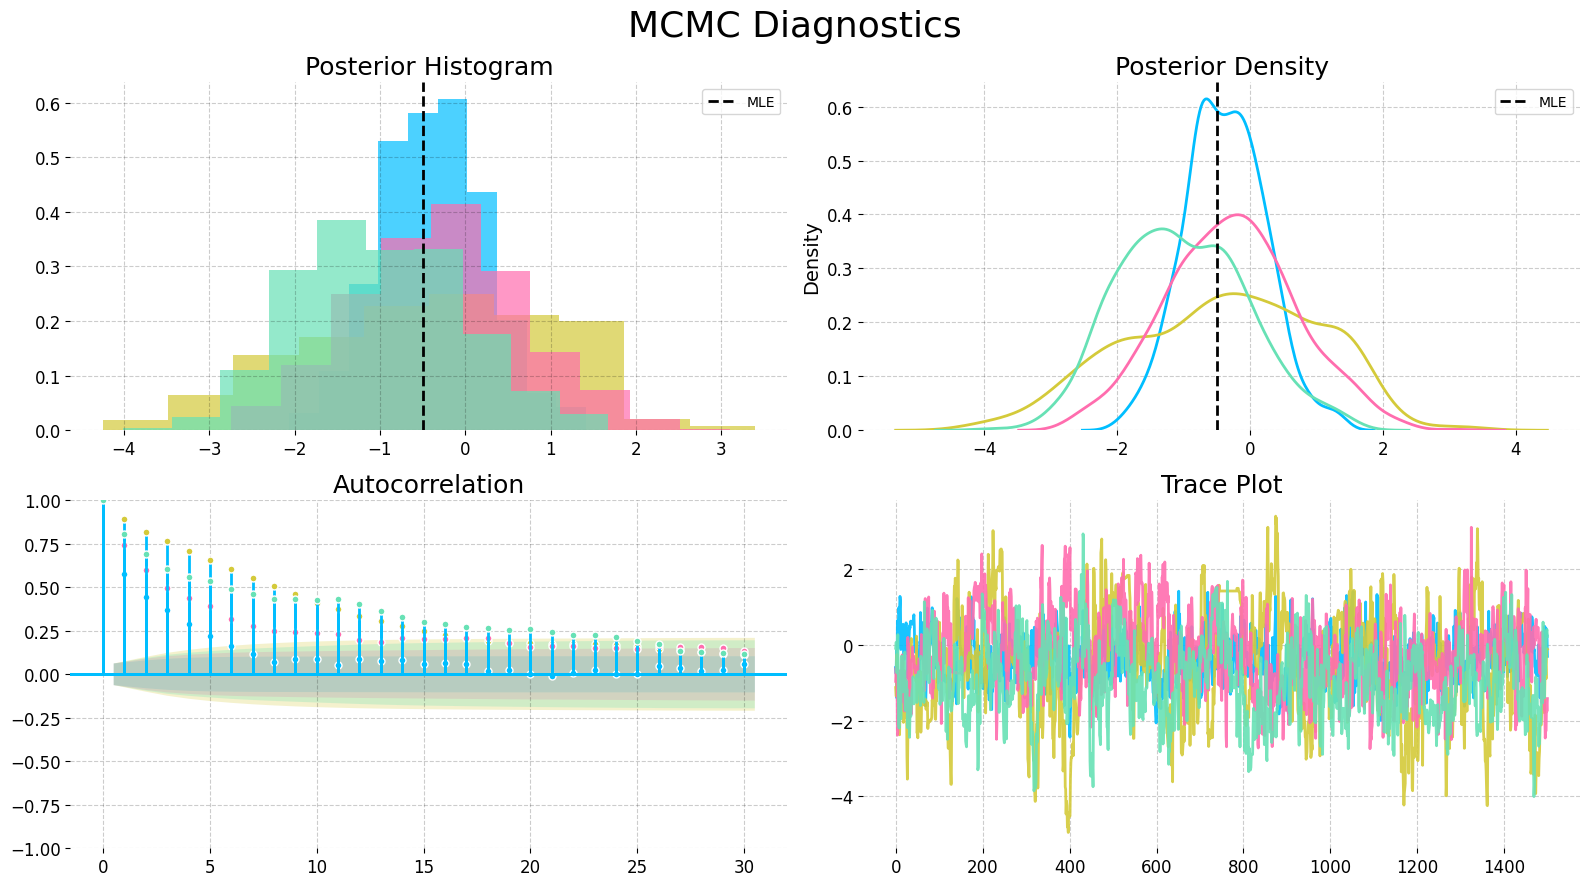

In [80]:
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
plt.style.use('matplotlibrc')
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(16,9))
skip = 1
col = 6
burnin=500
for chain in range(chains):
    ax[0,0].hist(thetas_chains[chain][burnin::skip,col], alpha=0.7, density=True)
    sns.kdeplot(thetas_chains[chain][burnin::skip,col], ax=ax[0,1])
    ax[1,1].plot(thetas_chains[chain][::skip,col], alpha=0.9)
    plot_acf(thetas_chains[chain][burnin::skip,col], ax=ax[1,0])
ax[0,0].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[0,1].axvline(theta[col], color='black', linestyle='--', label='MLE')
ax[0,0].set_title('Posterior Histogram')
ax[0,1].set_title('Posterior Density')
ax[1,1].set_title('Trace Plot')
ax[0,0].legend()
ax[0,1].legend()
plt.suptitle('MCMC Diagnostics', fontsize=26)
plt.tight_layout()
plt.show()
# NUTS EB

In [ ]:
def get_thetas(theta):
    gamma = np.exp(theta[0]) #rate at which I recovers
    m = np.exp(theta[1]) #probability of death from cholera
    rho = np.exp(theta[2]) #1/rho is mean duration of short-term immunity
    epsilon = np.exp(theta[3]) # 1/eps is mean duration of immunity
    omega = np.exp(theta[4]) #mean foi
    c = sigmoid(theta[5] ) #probability exposure infects
    beta_trend = theta[6] / 100 #trend in foi
    sigma = np.exp(theta[7]) #stdev of foi perturbations
    tau = np.exp(theta[8]) #stdev of gaussian measurements
    bs = theta[9:15] #seasonality coefficients
    omegas = theta[15:]
    k = 3# 1/(np.exp(theta[3])**2) #1/sqrt(k) is coefficient of variation of immune period
    delta = 0.02 #death rate
    return gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas, k, delta

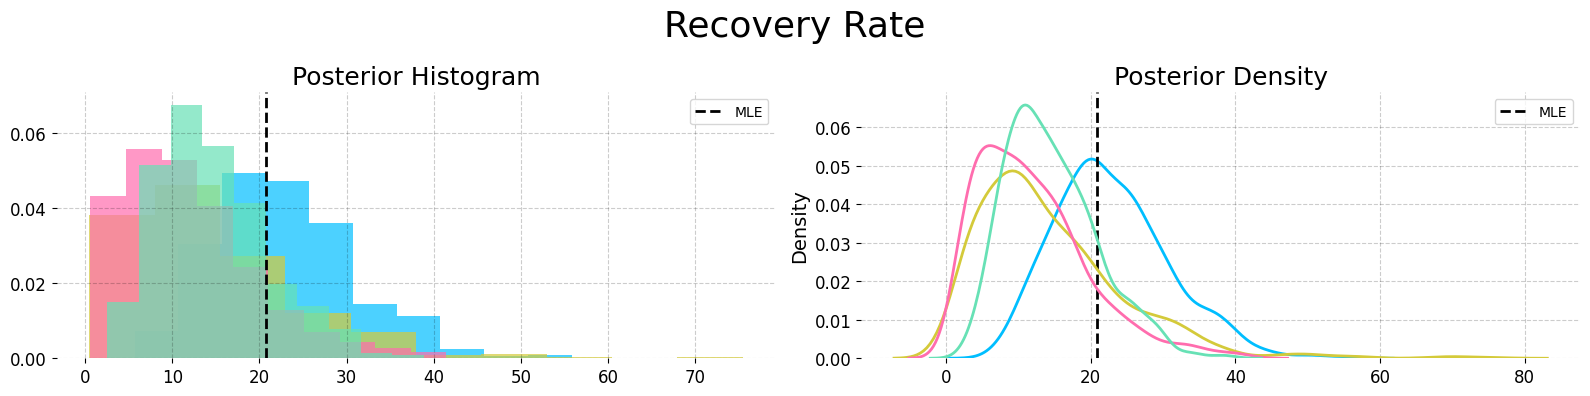

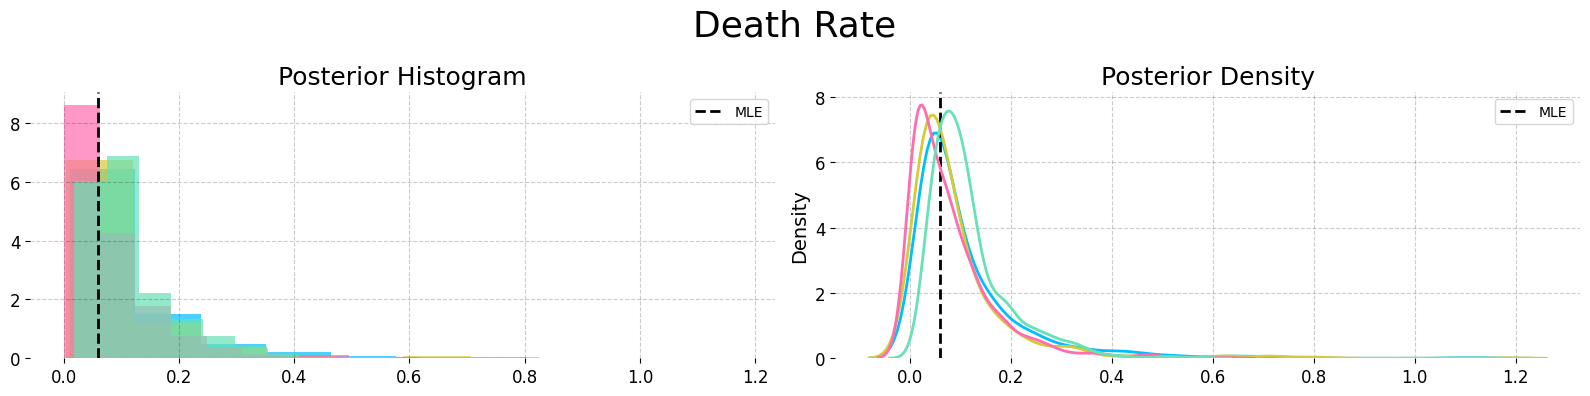

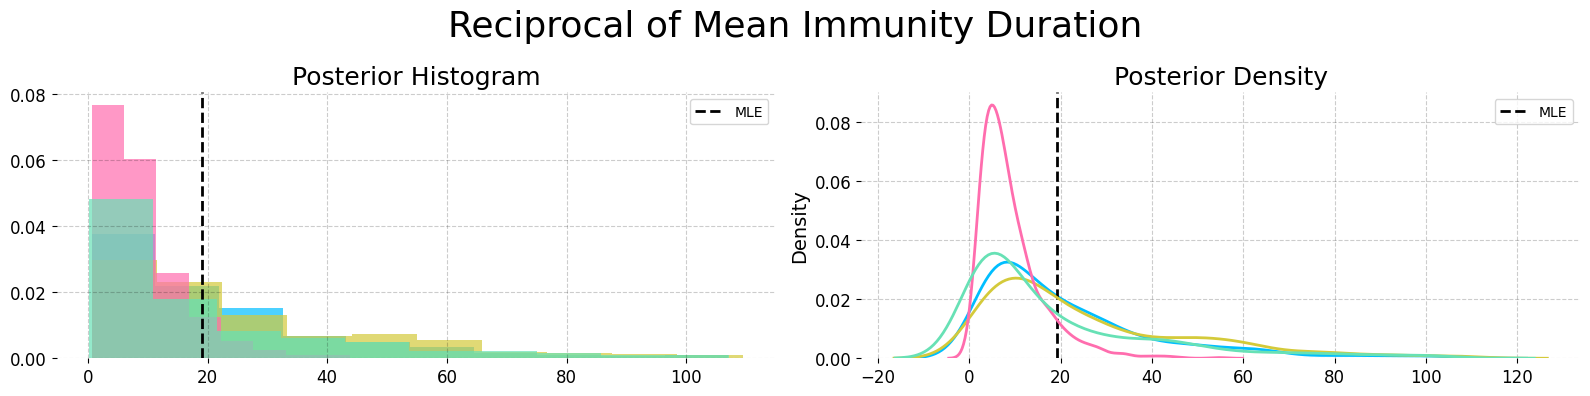

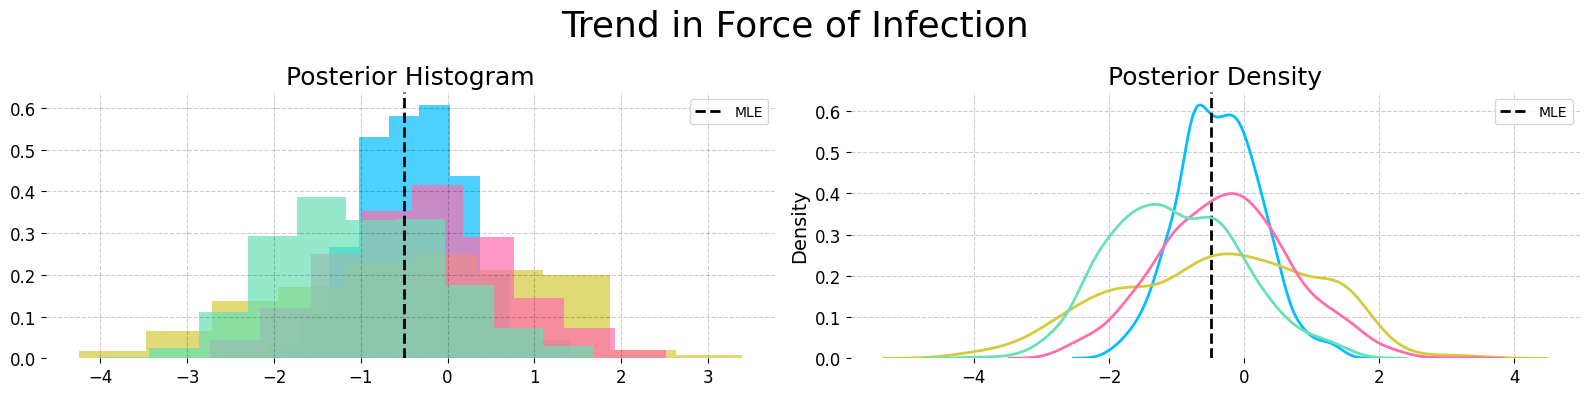

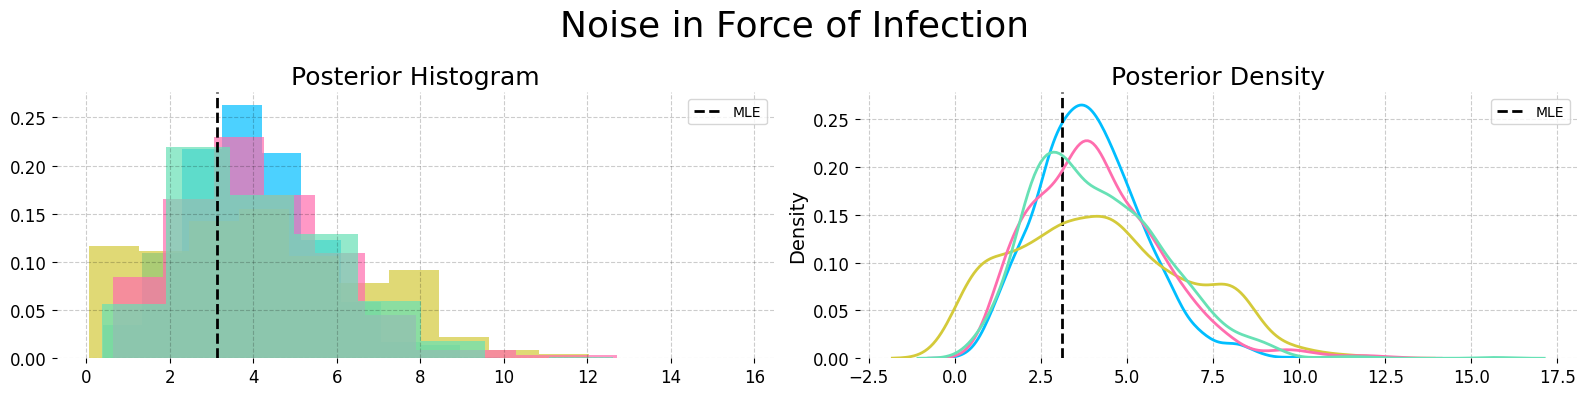

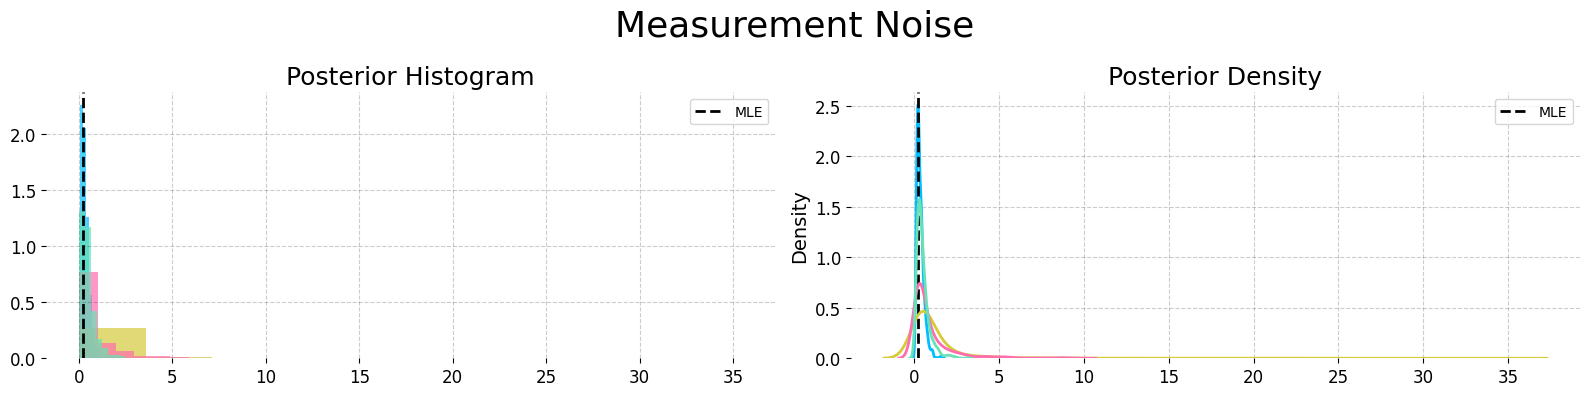

In [12]:
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
plt.style.use('matplotlibrc')
skip = 1
col = 6
burnin=500
cols = [0,1,3,6,7,8]
parameters = ['Recovery Rate', 'Death Rate', 'Reciprocal of Mean Immunity Duration',
              'Trend in Force of Infection',
              'Noise in Force of Infection', 
              'Measurement Noise']
              
              
for col, parameter in zip(cols,parameters):
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    for chain in range(chains):
        if parameter == 'Trend in Force of Infection':
            ax[0].hist(thetas_chains[chain][burnin::skip,col], alpha=0.7, density=True)
            sns.kdeplot(thetas_chains[chain][burnin::skip,col], ax=ax[1])
            if chain == 0:
                ax[0].axvline(theta[col], color='black', linestyle='--', label='MLE')
                ax[1].axvline(theta[col], color='black', linestyle='--', label='MLE')
        else:
            ax[0].hist(np.exp(thetas_chains[chain][burnin::skip,col]), alpha=0.7, density=True)
            sns.kdeplot(np.exp(thetas_chains[chain][burnin::skip,col]), ax=ax[1])
            if chain == 0:
                ax[0].axvline(np.exp(theta[col]), color='black', linestyle='--', label='MLE')
                ax[1].axvline(np.exp(theta[col]), color='black', linestyle='--', label='MLE')
    ax[0].set_title('Posterior Histogram')
    ax[1].set_title('Posterior Density')
    ax[0].legend()
    ax[1].legend()
    plt.suptitle(parameter, fontsize=26)
    plt.tight_layout()
    plt.savefig('imgs/pmcmc/nuts_eb/'+parameter+'.png', dpi=300)
    plt.show()
# NUTS EB